In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns 
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from keras import layers
from sklearn.metrics import confusion_matrix, classification_report

In [2]:
df=pd.read_csv(r"C:\Users\Lenovo\OneDrive\Documents\Data set\IMDB Dataset.csv")
df=df.sample(n=5000).reset_index(drop=True)
df.head()

,review,sentiment
0,This is possibly the worst film I've ever seen...,negative
1,Leonard Rossiter and Frances de la Tour carry ...,negative
2,Sam Kleinman (Peter Falk) comes to his son's p...,positive
3,This was the best Muppet movie I've seen ever!...,positive
4,I'll make this brief. This was a joy to watch....,positive


# preprocessing

In [3]:

import re
import html
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

# Initialize the stemmer and stopwords list
stemmer = PorterStemmer()
stop_words = set(stopwords.words('english'))

def clean_review_with_stopwords_and_stemming(review):
    # Decode HTML entities (like <br /> to actual line breaks)
    review = html.unescape(review)

    # Remove HTML tags (e.g., <br />)
    review = re.sub(r'<.*?>', '', review)

    # Convert to lowercase
    review = review.lower()

    # Remove non-alphabetic characters and digits
    review = re.sub(r'[^a-z\s]', '', review)

    # Tokenization: Split the review into words
    words = review.split()

    # Remove stopwords and apply stemming
    cleaned_words = [stemmer.stem(word) for word in words if word not in stop_words]

    # Rejoin the words back into a cleaned string
    cleaned_review = ' '.join(cleaned_words)

    return cleaned_review

# Assuming df is your DataFrame with reviews
df['review'] = df['review'].apply(clean_review_with_stopwords_and_stemming)

df



,review,sentiment
0,possibl worst film ive ever seen fact flimsi s...,negative
1,leonard rossit franc de la tour carri film wit...,negative
2,sam kleinman peter falk come son place unexpec...,positive
3,best muppet movi ive seen ever happen know mis...,positive
4,ill make brief joy watch may may effect charac...,positive
...,...,...
4995,grew scoobi doo still love one favourit cartoo...,negative
4996,terenc stamp carri anyth still shallow onedime...,negative
4997,r balki tri tell stori earlier told ram gopal ...,negative
4998,we craven creat success killerthril movi time ...,positive


# ENcoding

In [4]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
df['sentiment'] = encoder.fit_transform(df['sentiment'])
df.head()

,review,sentiment
0,possibl worst film ive ever seen fact flimsi s...,0
1,leonard rossit franc de la tour carri film wit...,0
2,sam kleinman peter falk come son place unexpec...,1
3,best muppet movi ive seen ever happen know mis...,1
4,ill make brief joy watch may may effect charac...,1


# Train and Test

In [5]:
RANDOM_STATE = 42
text_train, text_test, y_train, y_test = train_test_split(df['review'], df['sentiment'], test_size=0.1, random_state=RANDOM_STATE)

In [11]:
tokenizer=Tokenizer()
tokenizer.fit_on_texts(text_train)

X_train = tokenizer.texts_to_sequences(text_train)
X_test = tokenizer.texts_to_sequences(text_test)

vocab_size = len(tokenizer.word_index) + 1  # Adding 1 because of reserved 0 index
maxlen = max(len(x) for x in X_train) # longest text in train set

# Add padding to ensure all vectors have the same dimensionality
X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

X_train

array([[1129,  721,  780, ...,    0,    0,    0],
       [ 134,   13, 8779, ...,    0,    0,    0],
       [ 290,   30,   15, ...,    0,    0,    0],
       ...,
       [3767, 2599,  121, ...,    0,    0,    0],
       [ 397,  238,  190, ...,    0,    0,    0],
       [  22,   38,   23, ...,    0,    0,    0]],
      shape=(4500, 636), dtype=int32)

# CNN Architecture

In [13]:
from tensorflow.keras import layers, Sequential

embedding_dim = 100

model = Sequential()
model.add(layers.Embedding(vocab_size, embedding_dim, input_length=maxlen))
model.add(layers.Conv1D(128, 5, activation='relu'))
model.add(layers.GlobalMaxPool1D())  # ✅ Fix: Added parentheses
model.add(layers.Dense(10, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))  # Output layer for binary classification

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


In [14]:
history = model.fit(X_train, y_train, epochs=5,batch_size=64,verbose=True, validation_data=(X_test, y_test))

Epoch 1/5
71/71 ━━━━━━━━━━━━━━━━━━━━ 26s 193ms/step - accuracy: 0.6531 - loss: 0.6541 - val_accuracy: 0.7220 - val_loss: 0.5419
Epoch 2/5
71/71 ━━━━━━━━━━━━━━━━━━━━ 14s 192ms/step - accuracy: 0.8291 - loss: 0.3986 - val_accuracy: 0.8600 - val_loss: 0.3486
Epoch 3/5
71/71 ━━━━━━━━━━━━━━━━━━━━ 20s 189ms/step - accuracy: 0.9540 - loss: 0.1569 - val_accuracy: 0.8600 - val_loss: 0.3263
Epoch 4/5
71/71 ━━━━━━━━━━━━━━━━━━━━ 13s 188ms/step - accuracy: 0.9978 - loss: 0.0327 - val_accuracy: 0.8480 - val_loss: 0.3392
Epoch 5/5
71/71 ━━━━━━━━━━━━━━━━━━━━ 14s 195ms/step - accuracy: 1.0000 - loss: 0.0069 - val_accuracy: 0.8360 - val_loss: 0.3768


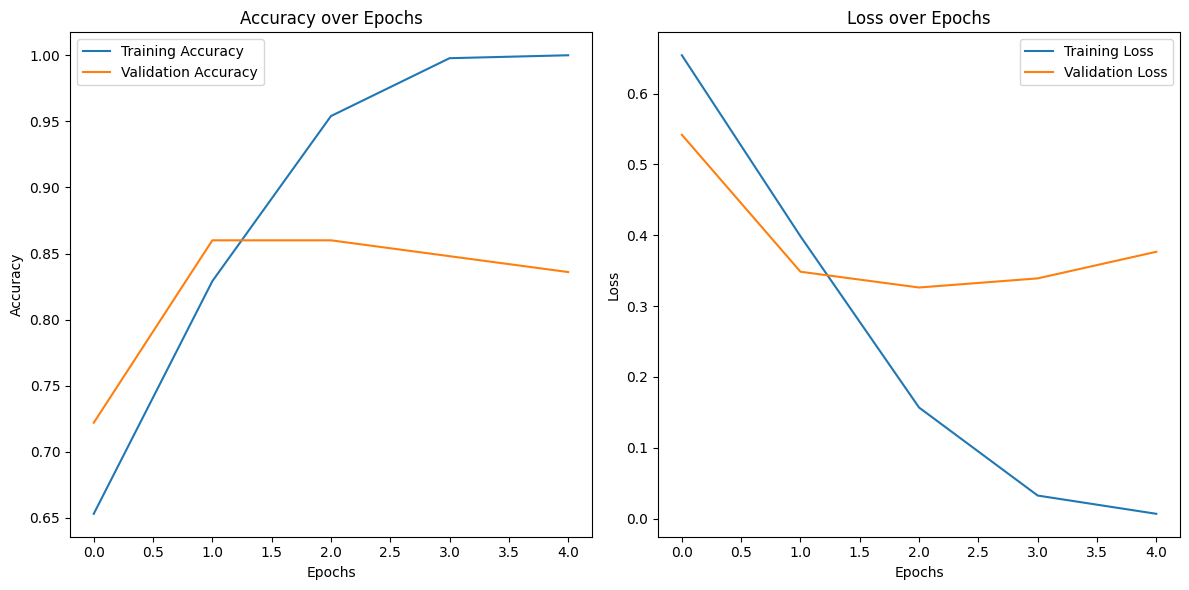

In [15]:
import matplotlib.pyplot as plt

# Plot accuracy
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Display the plots
plt.tight_layout()
plt.show()

# Confusion and Classification Report

16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 74ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.78      0.83       251
           1       0.80      0.89      0.84       249

    accuracy                           0.84       500
   macro avg       0.84      0.84      0.84       500
weighted avg       0.84      0.84      0.84       500



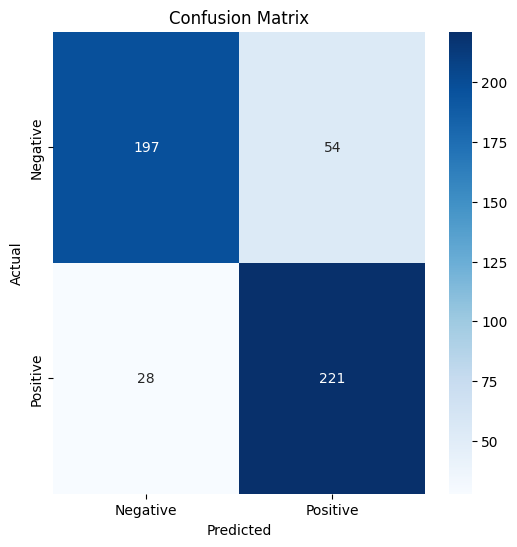

In [16]:
# Predict on the test data
y_pred = (model.predict(X_test) > 0.5).astype(int)

# Classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))


# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()




# Predict script

In [ ]:
def predict_sentiment(review):
    text=clean_review_with_stopwords_and_stemming(review)
    sequence=tokenizer.texts_to_sequences([text])
    padded_sequence = pad_sequences(sequence, padding='post', maxlen=maxlen)

    prediction = model.predict(padded_sequence)[0][0]

    if prediction > 0.5:
     return "Positive"
    else:
      return "Negative"